# Trailer Soundtrack Classification

In [1]:
from __future__ import print_function

In [2]:
#!pip install librosa

In [3]:
# We'll need numpy for some mathematical operations
import numpy as np


# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline


# and IPython.display for audio output
import IPython.display


# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display
import glob
import os

from matplotlib.pyplot import specgram
from sklearn import preprocessing

## Mel spectrogram 

In [4]:
def show_mel_spectogram(audio_path):
    y, sr = librosa.load(audio_path)
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.power_to_db(S, ref=np.max)

    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()
    plt.show()

## Harmonic-percussive source separation

In [5]:
def show_harmonic_percussive_separation(audio_path):
    y, sr = librosa.load(audio_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    # What do the spectrograms look like?
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
    S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
    log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

    # Make a new figure
    plt.figure(figsize=(12,6))

    plt.subplot(2,1,1)
    # Display the spectrogram on a mel scale
    librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram (Harmonic)')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    plt.subplot(2,1,2)
    librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram (Percussive)')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()
    plt.show()

## Chromagram

Chroma features to represent pitch class information.

In [6]:
def show_pitch_chromagram(audio_path):    
    y, sr = librosa.load(audio_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    # We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
    # We'll use the harmonic component to avoid pollution from transients
    C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the chromagram: the energy in each chromatic pitch class as a function of time
    # To make sure that the colors span the full range of chroma values, set vmin and vmax
    librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

    plt.title('Chromagram')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

## MFCC

Mel-frequency cepstral coefficients are commonly used to represent texture or timbre of sound.

In [7]:
def show_mfcc_textures(audio_path):    
    y, sr = librosa.load(audio_path)
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    # Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
    mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

    # Let's pad on the first and second deltas while we're at it
    delta_mfcc  = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # How do they look?  We'll show each in its own subplot
    plt.figure(figsize=(12, 6))

    plt.subplot(3,1,1)
    librosa.display.specshow(mfcc)
    plt.ylabel('MFCC')
    plt.colorbar()

    plt.subplot(3,1,2)
    librosa.display.specshow(delta_mfcc)
    plt.ylabel('MFCC-$\Delta$')
    plt.colorbar()

    plt.subplot(3,1,3)
    librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
    plt.ylabel('MFCC-$\Delta^2$')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Beat tracking

The beat tracker returns an estimate of the tempo (in beats per minute) and frame indices of beat events.

In [8]:
def show_beat_tracking(audio_path):
    y, sr = librosa.load(audio_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    # Now, let's run the beat tracker.
    # We'll use the percussive component for this part
    plt.figure(figsize=(12, 6))
    tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.power_to_db(S, ref=np.max)

    # Let's re-draw the spectrogram, but this time, overlay the detected beats
    plt.figure(figsize=(12,4))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

    # Let's draw transparent lines over the beat frames
    plt.vlines(librosa.frames_to_time(beats),
               1, 0.5 * sr,
               colors='w', linestyles='-', linewidth=2, alpha=0.5)

    plt.axis('tight')

    plt.colorbar(format='%+02.0f dB')

    plt.tight_layout()
    plt.show()
    print('Estimated tempo:        %.2f BPM' % tempo)
    print('First 5 beat frames:   ', beats[:5])
    # Frame numbers are great and all, but when do those beats occur?
    print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

## Beat-synchronous feature aggregation

Summarizes the feature content of each beat.

In [9]:
def show_beat_synchronous_feature_aggregation(audio_path):
    # feature.sync will summarize each beat event by the mean feature vector within that beat
    y, sr = librosa.load(audio_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    # Now, let's run the beat tracker.
    # We'll use the percussive component for this part
    plt.figure(figsize=(12, 6))
    tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    # Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
    mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    # Let's pad on the first and second deltas while we're at it
    delta_mfcc  = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    M_sync = librosa.util.sync(M, beats)

    plt.figure(figsize=(12,6))

    # Let's plot the original and beat-synchronous features against each other
    plt.subplot(2,1,1)
    librosa.display.specshow(M)
    plt.title('MFCC-$\Delta$-$\Delta^2$')

    # We can also use pyplot *ticks directly
    # Let's mark off the raw MFCC and the delta features
    plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

    plt.colorbar()

    plt.subplot(2,1,2)
    # librosa can generate axis ticks from arbitrary timestamps and beat events also
    librosa.display.specshow(M_sync, x_axis='time',
                             x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

    plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
    plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

## Voice separation

In [10]:
def show_voice_separation(audio_path):
    y, sr = librosa.load(audio_path)
    # And compute the spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(y))
    # We'll compare frames using cosine similarity, and aggregate similar frames
    # by taking their (per-frequency) median value.
    #
    # To avoid being biased by local continuity, we constrain similar frames to be
    # separated by at least 2 seconds.
    #
    # This suppresses sparse/non-repetetitive deviations from the average spectrum,
    # and works well to discard vocal elements.

    S_filter = librosa.decompose.nn_filter(S_full,
                                           aggregate=np.median,
                                           metric='cosine',
                                           width=int(librosa.time_to_frames(2, sr=sr)))

    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimium
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)
    # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
    # Note: the margins need not be equal for foreground and background separation
    margin_i, margin_v = 2, 10
    power = 2

    mask_i = librosa.util.softmask(S_filter,
                                   margin_i * (S_full - S_filter),
                                   power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                                   margin_v * S_filter,
                                   power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                             y_axis='log', sr=sr)
    plt.title('Background')
    plt.colorbar()
    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                             y_axis='log', x_axis='time', sr=sr)
    plt.title('Foreground')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

## Extracting sound features

In [11]:
def extract_tempo_bpm(audio_path):
    y, sample_rate = librosa.load(audio_path)
    #S = librosa.feature.melspectrogram(y, sr=sample_rate, n_mels=128)
    #log_S = librosa.power_to_db(S, ref=np.max)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo_bpm, beats = librosa.beat.beat_track(y=y_percussive, sr=sample_rate)
    #stft = np.abs(librosa.stft(y))
    #mfcc        = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=40)
    #mfccs = np.mean(mfcc.T,axis=0)
    #chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    #mel = np.mean(librosa.feature.melspectrogram(y, sr=sample_rate).T,axis=0)
    #contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=y_harmonic,sr=sample_rate).T,axis=0)
    #print(len(mfccs))
    #print(len(chroma_stft))
    #print(len(mel))
    #print(len(contrast))
    #print(len(tonnetz))
    return tempo_bpm

## Action Sample 

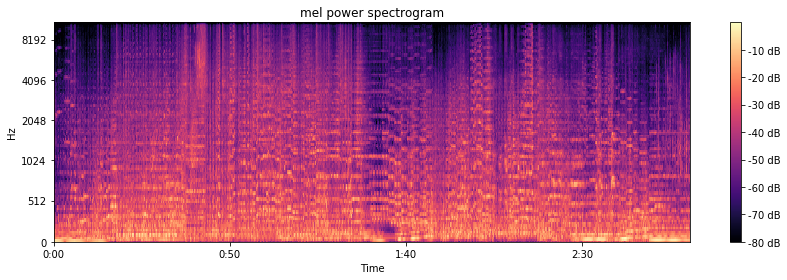

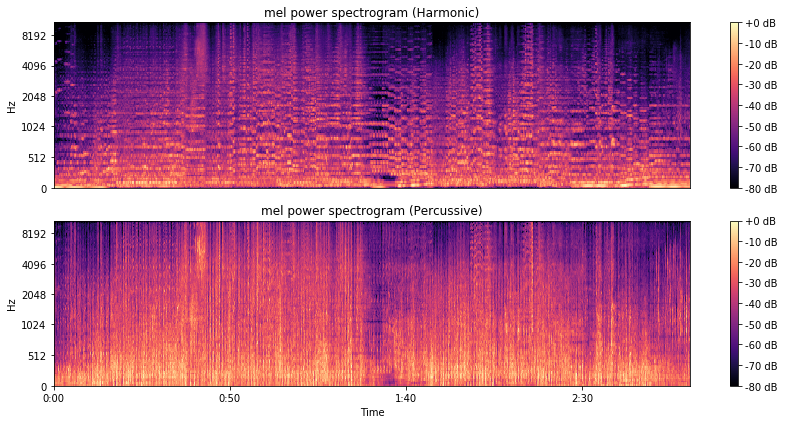

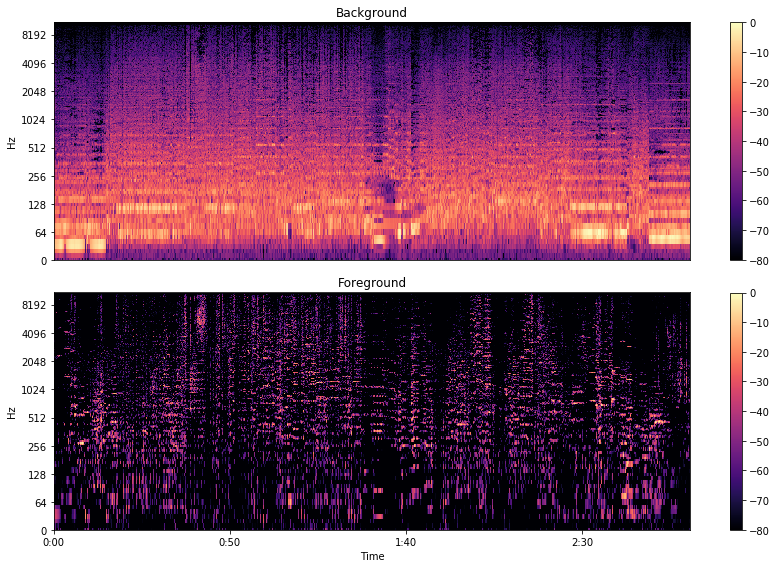

135.99917763157896

In [12]:
audio_path = 'download_audio/wav/Action___BatmanReturns.wav'
show_mel_spectogram(audio_path)
show_harmonic_percussive_separation(audio_path)
show_voice_separation(audio_path)
extract_tempo_bpm(audio_path)

# Adventure

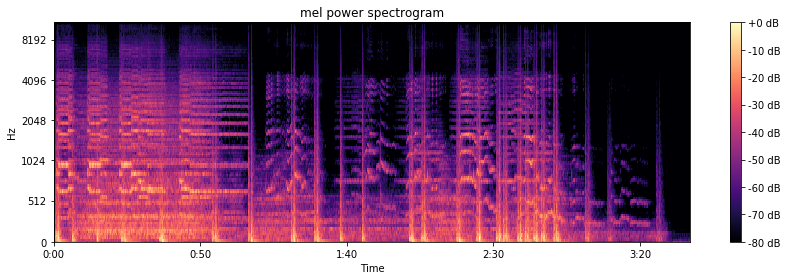

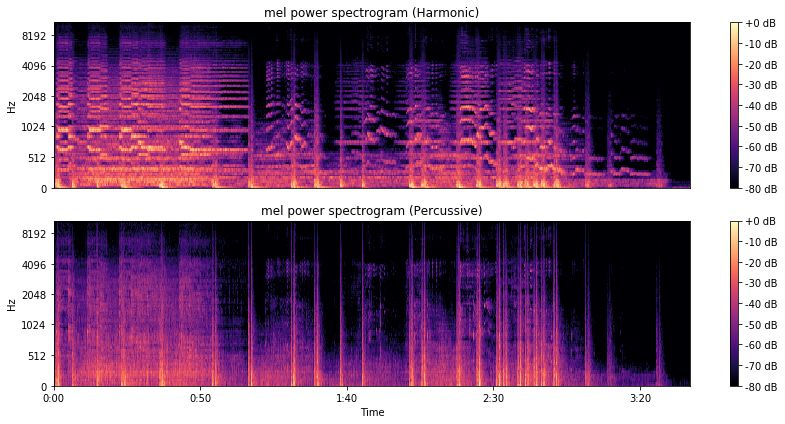

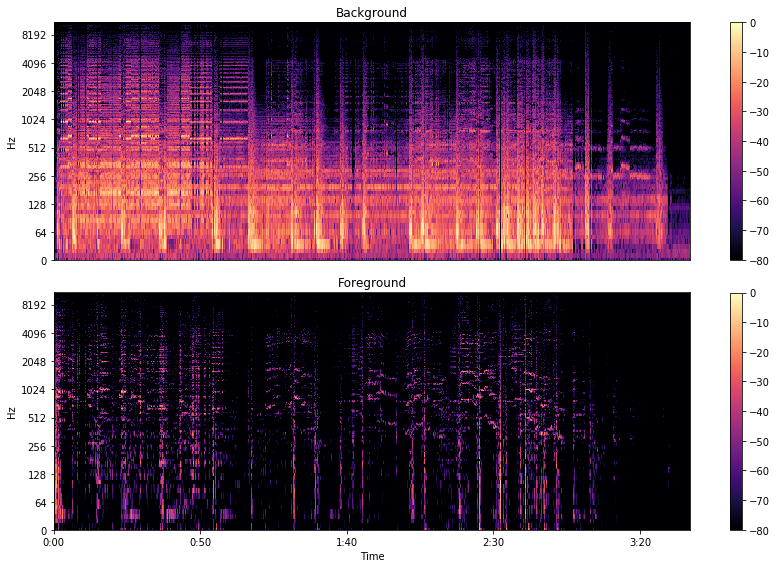

135.99917763157896

In [13]:
audio_path = 'download_audio/wav/Adventure___Troy.wav'
show_mel_spectogram(audio_path)
show_harmonic_percussive_separation(audio_path)
show_voice_separation(audio_path)
extract_tempo_bpm(audio_path)

# Comedy

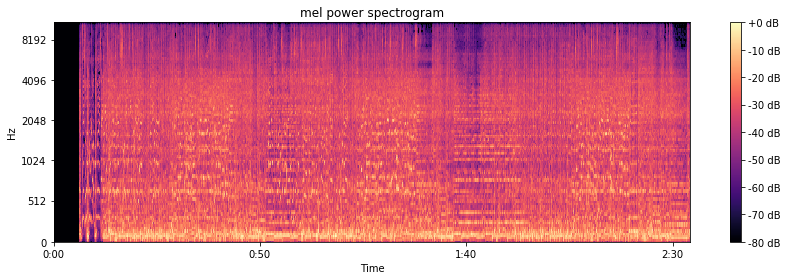

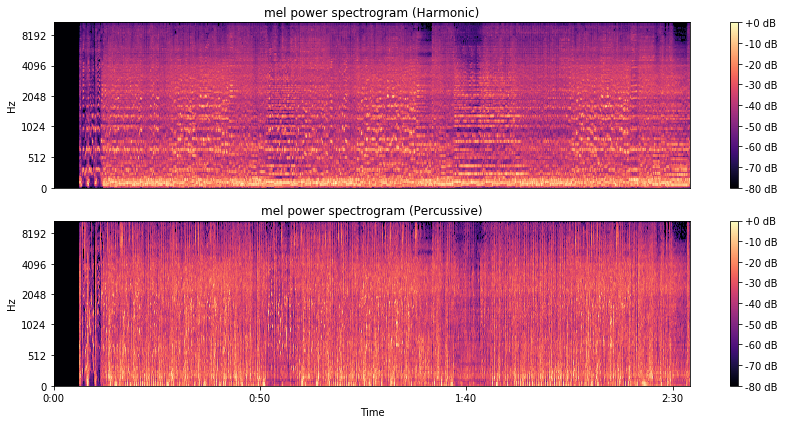

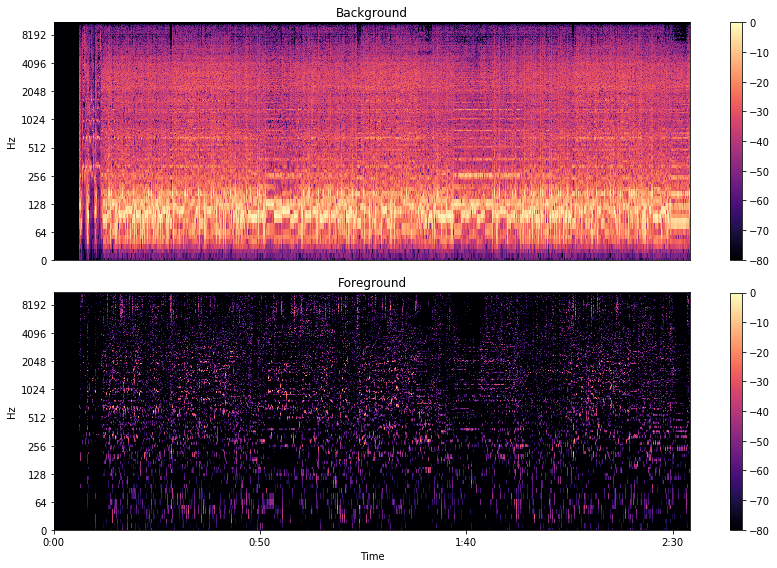

135.99917763157896

In [14]:
audio_path = 'download_audio/wav/Comedy___AmericanPie2.wav'
show_mel_spectogram(audio_path)
show_harmonic_percussive_separation(audio_path)
show_voice_separation(audio_path)
extract_tempo_bpm(audio_path)

# Drama

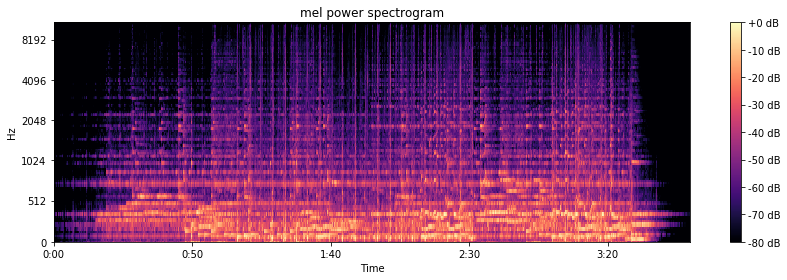

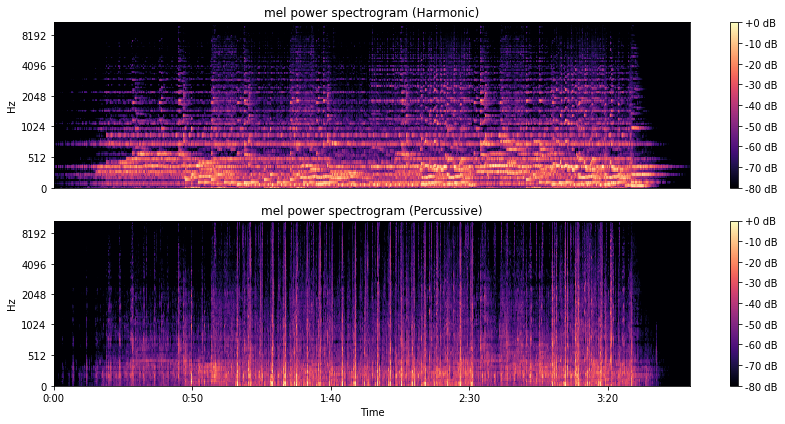

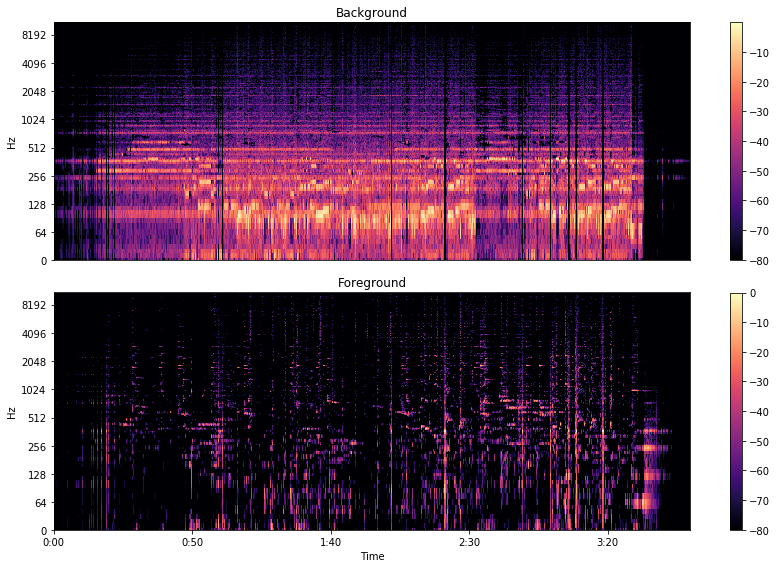

151.99908088235293

In [15]:
audio_path = 'download_audio/wav/Drama___Biutiful.wav'
show_mel_spectogram(audio_path)
show_harmonic_percussive_separation(audio_path)
show_voice_separation(audio_path)
extract_tempo_bpm(audio_path)

# Crime

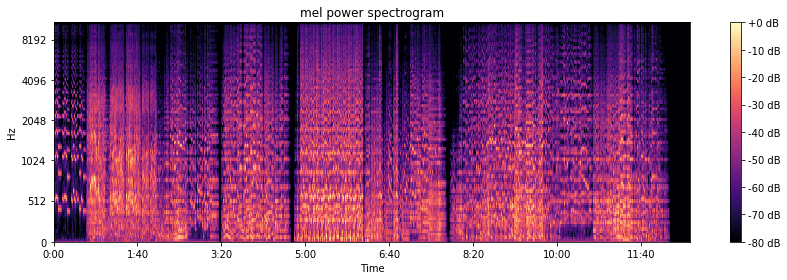

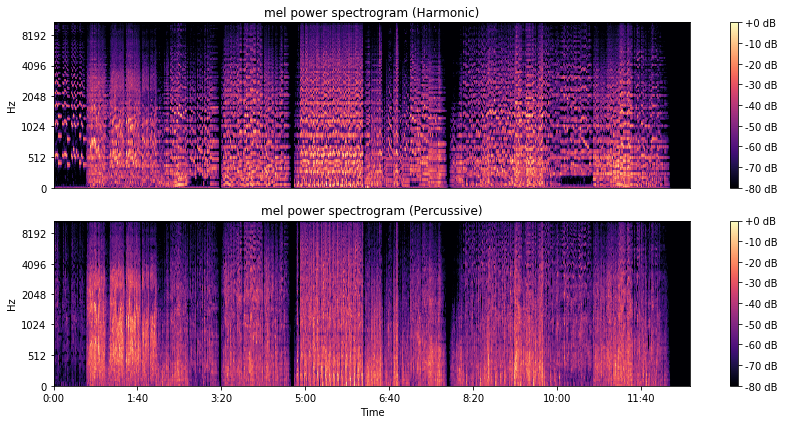

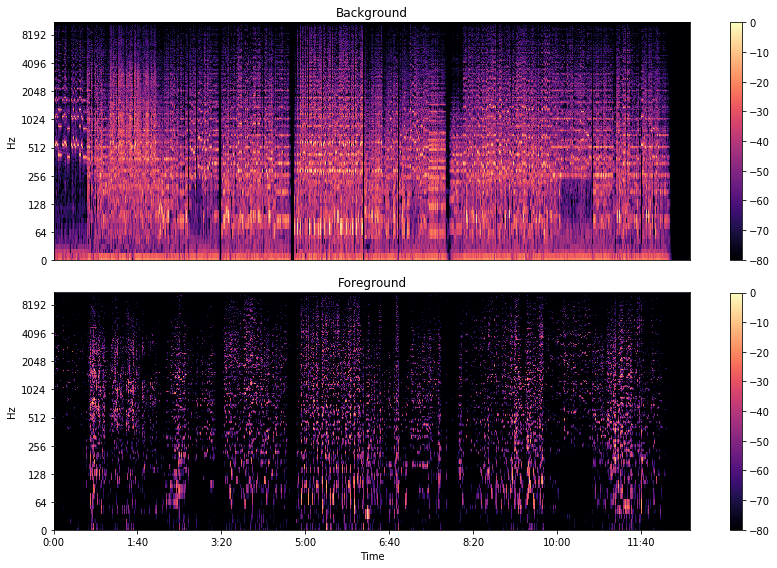

112.34714673913044

In [16]:
audio_path = 'download_audio/wav/Crime_Drama___TheGodfatherPartIII.wav'
show_mel_spectogram(audio_path)
show_harmonic_percussive_separation(audio_path)
show_voice_separation(audio_path)
extract_tempo_bpm(audio_path)

# Horror

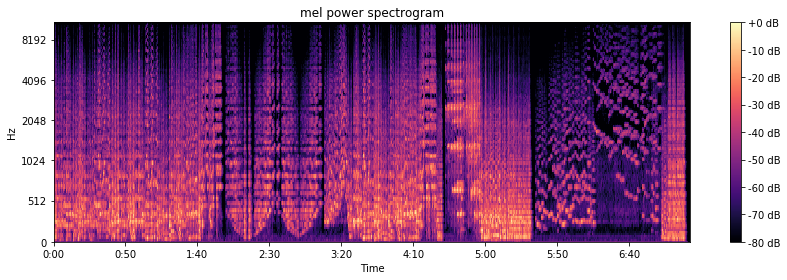

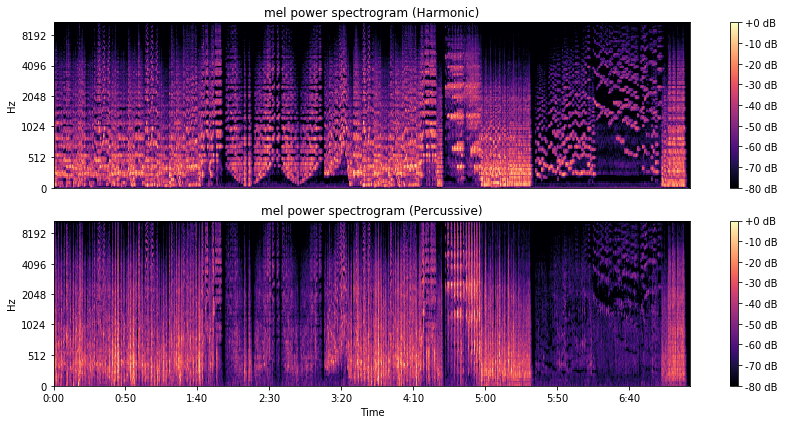

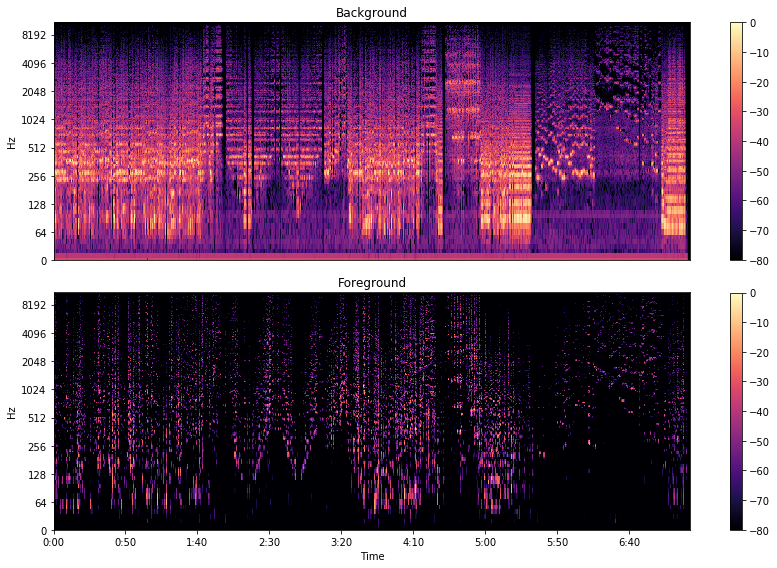

143.5546875

In [17]:
audio_path = 'download_audio/wav/Horror_Mystery_Thriller___Psycho.wav'
show_mel_spectogram(audio_path)
show_harmonic_percussive_separation(audio_path)
show_voice_separation(audio_path)
extract_tempo_bpm(audio_path)

# Western

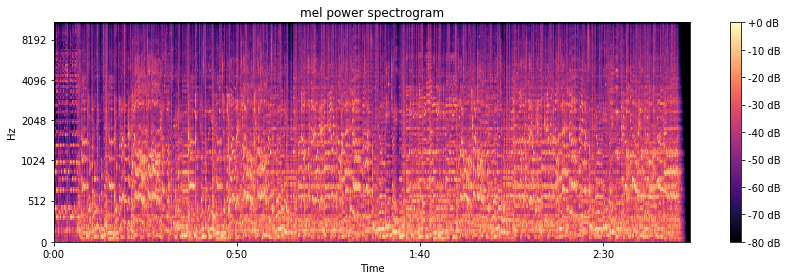

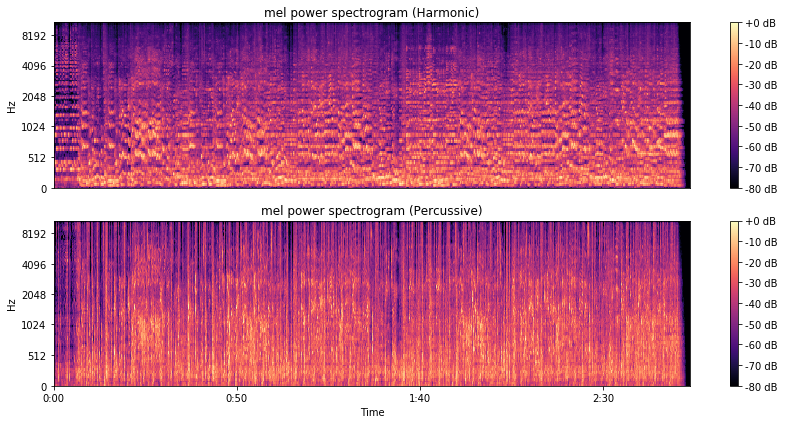

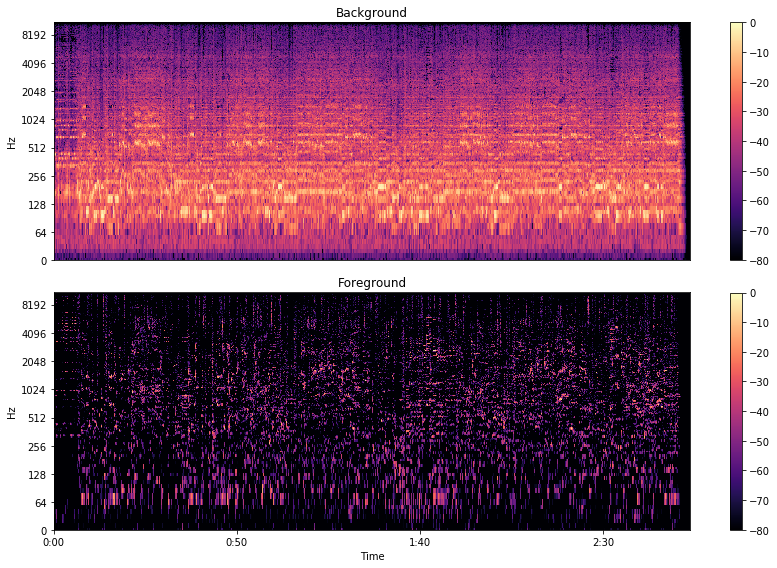

99.38401442307692

In [18]:
audio_path = 'download_audio/wav/Drama_Western___DjangoUnchained.wav'
show_mel_spectogram(audio_path)
show_harmonic_percussive_separation(audio_path)
show_voice_separation(audio_path)
extract_tempo_bpm(audio_path)